In [1]:
%matplotlib inline
import numpy as np
from numpy import fft

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import Video
Writer = animation.writers['ffmpeg']
writer1 = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)

# Time-Dependent Schrodinger Equation
The time-dependent Schrodinger equation is a bit difference from the time independent equation.
\begin{align}
i h \frac{\partial}{\partial x} \psi (x,t) = H \psi\\
H = -\frac{\hbar^2}{2m} \nabla^2 + V(x,t)
\end{align}

Where $H$ is the enegy hamiltonian of the system, meaning that because $V(x,t)$ is a time varying potential, then the laplacian term must be the kinetic term.

This PDE is quite daunting until one applies seperation of variables to discover that the time evolution of the schrodinger equation is just a extension of the time independent equation, which is multiplied by a phase term $e^{-iHt/\hbar}$ to get the solution to the time dependent schrodinger equation.

... But this isn't always that useful in practice, evolving forward the eigenstates of the time independent solution is useful in the context of certain contexts and potentials, such as solving the schrodinger equation in a infinite square well, however, for arbitrary initial conditions, while the particle will eventually settle into the time independent steady state solution, we can say very little about the transient solution (going from initial conditions to the steady state), particularly if the potential is non-linear. 
Further, our entire assumption of seperability goes out the window if the potential is time varying.

This clearly poses a problem, there are certainly intresting problems we might want to model, such as how a electron settles into a bond orbital as this could effect the initial stability of a chemical compound during bonding, or the dynamic interaction of multiple particles in a system. However, our current tools provide little to nothing of use to these problems.

## Numerical Methods
This is where the numerical solutions of the TDSE become quite useful. The construction of the Schrodinger Equation easily emits a formula for the time derivitive of $\psi$ at any given point. Thus, given a initial condition of the system, we should be able to solve this as a simple discritized finite differences (computing derivitives locally from a descritized domain) problem. However, we run into some complications. For one, we know that the actual function of the time evolution we are approximating is a complex exponential ( $e^{-iH\delta t/\hbar}$) for every time step, which is inherently unstable because any small purterbation to the real part will cause a, literally, exponenital difference in the output. This is a problem because second order finite differences methods (such as Runge-Kutta) is generally our go to tool for time evolution of states. However, the idea is still attractive because over very small time horizons, we can treat our potential as constant in time and also treat the current state of $\psi$ as the solution to some TISE which is being time evolved with our simple phase term. Because we are multiplying by each exponential at each timestep, and products of exponentials are a exponential of the sum of the exponential terms, this should still work out to being the correct time evolution.

In numerical analysis, when a system is particularly siff, such as some propogations of the schrodinger equation, we often try and solve this with a implicit method, where we solve a optimization problem to find the most likely next state by estimating what the derivitive will be at the next state, and then steping backwards in time from there to try and find our current state. Instability is only in one direction of time, thus, because this effectively solves backwards in time, it will be stable for any unstable problem. Indeed, a version of this is often used for time evolving the schrodinger equation, in a approximation known as the Crank-Nicolson Approximation, which is always stable in both forward and backwards time. However, these optimization problems often emmit numerically unsuitable solutions which degrade the accuracy of the solution.

So far, the quest for TDSE evolution in arbitary potentials is grim, while our descritized exponential is theoretically sound, our forward propogation is either unstable in space or time. However, we do know some things about the actual quantum mechanics at the heart of all of this math. For one, momentum is quantized discretely for any true solution of the schrodinger equation. And in our simulation, because space is quantized discretely, so is the potential. The crux of our problem is really the laplacian term in the hamiltonian, because our approximations of spacial derivitives are inaccurate, making all of our solutions unstable. 
If only there was some way of relating functions in space to functions of momentum, and then a easy way to take a derivitive which would not rely on a finite differences approximation. 

## Split-Step Operator Method
Fortunately for us, the Fourier transform does just this, and the Fast Fourier Transform (FFT) is a very efficient and accurate way of computing this on a computer. The fourier transform allows us to transform into momentum (phase) space and operate on the function from there. In Phase space, derivitives are taken by multiplying by the phase variable times i. This makes it extremely easy to find the laplacian in phase space as one simply has the multiply by $-k$. Because the fourier transform accounts for the function at all points at once going into phase space, this same operation with the fast fourier transform can be thought of as a high order approximation of the laplacian which global convergence as the the number of quantized momenta grows large. What is better, is that in quantum mechanics, we have one expected wavenumber along with some uncertainty surrounding it. Because this is proportional to momentum, we know that, in momentum space, the function we are operating on will be quite simple, and conserving the wave number through steps should be trivial for the fourier transform. By taking the laplacian with the fourier transform and applying the locally time independent potential assumption, we have stumbled on a variation of the Split-Step Operator Method, a spectral method for integrating the TDSE in time. 

\begin{align}
\psi(x, t + \delta t) = e^{-iV(x,t) \delta t /2\hbar} \mathbb{F}^{-1} [ e^{-ik^2 \delta t / 2m\hbar}\mathbb{F}[\psi(x,t)]] + O(\delta t^2)
\end{align}

For certain solutions, Strang Splitting can also be applied to further improve performance. 
A Implementation of this is given below:


In [2]:
class TDSE_sim:
    def __init__(self, initial_position=0.0, uncertainty=0.5, wavenumber=40.0, domain=10.0, wavepacket_scaling=0.5, spacial_resolution=2**10, dt=1e-4, sim_length=1.0):
        self.spatial_res = spacial_resolution
        self.dt = dt
        self.num_timesteps = int(sim_length/dt)
        self.domain = domain
        # allow for periodic boundary conditions
        self.x = np.linspace(-self.domain/2, self.domain/2, num=self.spatial_res+1)[0:-1]
        self.k = 2*np.pi/(2*self.domain) * np.arange(-self.spatial_res/2, self.spatial_res/2)
        self.dx = self.x[1] - self.x[0]
        
        #self.psi = np.exp(1.0j * wavenumber * (self.x - initial_position)) * np.exp(-np.power(((self.x - initial_position)) / wavepacket_scaling, 2))
        self.psi = (np.exp(-(self.x - initial_position)**2 /(4 * uncertainty**2)) * np.exp(1.0j * wavenumber * self.x))/((2 * np.pi * uncertainty**2)**(1.0/4))
        self.V = np.zeros_like(self.x)
        
        self.total_energy = []
        self.total_energy_timesteps = []
    
    def stepn(self, n):
        for i in range(n):
            psi_phase = np.fft.fftshift(np.fft.fft(self.psi))
            if i == 0:
                self.total_energy.append( np.abs(np.sum( np.fft.ifft(np.fft.ifftshift(psi_phase* 2*self.k)) + self.V )))

            
            # Kinetic Term
            psi_phase = np.exp(self.dt * -1.0j * (self.k**2)/2) * psi_phase
            psi = np.fft.ifft(np.fft.ifftshift(psi_phase))
            # Potential Term
            self.psi = np.exp(-1.0j * self.dt * self.V) * psi
        if len(self.total_energy_timesteps):
            self.total_energy_timesteps.append(self.total_energy_timesteps[-1] + n * self.dt)
        else:
            self.total_energy_timesteps.append(0)
            

# Example 1: Infinite Square Well Approximation
For a first experiment, we revisit the infinite square well, where we approximate a infinite square well with a continuous, piecewise function which grows extremely large after a certain point. We use this continuous function to ensure that the laplacian will be well defined for every point on the domain which helps with stability of the simulation. This is why it will appear that the wave part of $\psi$ extends too far into the well wall.

We get our initial conditions from the wavepacket solution to the TISE with a given wave number. For the purposes of numerical stability, $\hbar =1$. 

The following sims are run with a wavenumber of 5 and 40 to compare the output

In [3]:
sim = TDSE_sim(wavenumber=5, domain=20)
# infinite potential well
sim.V[sim.x < -8] = 1e3* (sim.x[sim.x < -8]+8)**2
sim.V[sim.x > 8] = 1e3*(sim.x[sim.x > 8]-8)**2

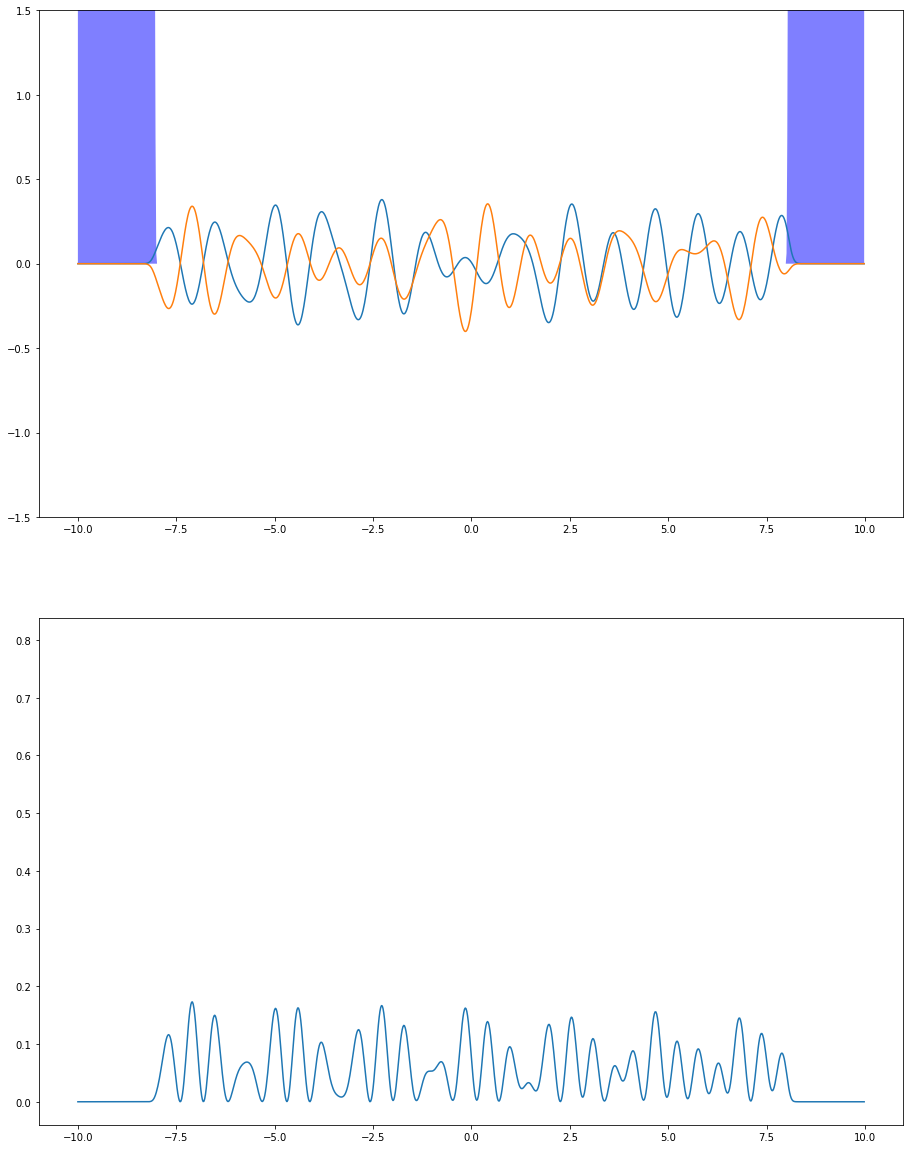

In [4]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(15.5, 20.5)
ax[0].set_ylim(-1.5, 1.5)
real_plot = ax[0].plot(sim.x, np.real(sim.psi))
imag_plot = ax[0].plot(sim.x, np.imag(sim.psi))
V_plot = ax[0].fill_between(sim.x, sim.V,facecolor='blue', alpha=0.5)
#prob_plot = plt.plot(sim.x, np.abs(sim.psi)**2)
#neg_prob_plot = plt.plot(sim.x, -np.abs(sim.psi)**2)
prob_plot = ax[1].plot(sim.x, np.abs(sim.psi)**2)
#energy_plot = ax[2].plot(sim.total_energy_timesteps, np.abs(sim.total_energy))

def animate(frame):
    sim.stepn(int(5e2))
    real_plot[0].set_data(sim.x, np.real(sim.psi))
    imag_plot[0].set_data(sim.x, np.imag(sim.psi))
    prob_plot[0].set_data(sim.x, np.abs(sim.psi)**2)
    #energy_plot[0].set_data(sim.total_energy_timesteps, np.abs(sim.total_energy))
    #prob_plot[0].set_data(sim.x, np.abs(sim.psi)**2)
    #neg_prob_plot[0].set_data(sim.x, -np.abs(sim.psi)**2)
anim = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
anim.save('infinite_square_well.mp4', writer=writer1)

In [5]:
Video('infinite_square_well.mp4')

In [6]:
sim = TDSE_sim(wavenumber=40, domain=20)
# infinite potential well
sim.V[sim.x < -8] = 1e3* (sim.x[sim.x < -8]+8)**2
sim.V[sim.x > 8] = 1e3*(sim.x[sim.x > 8]-8)**2

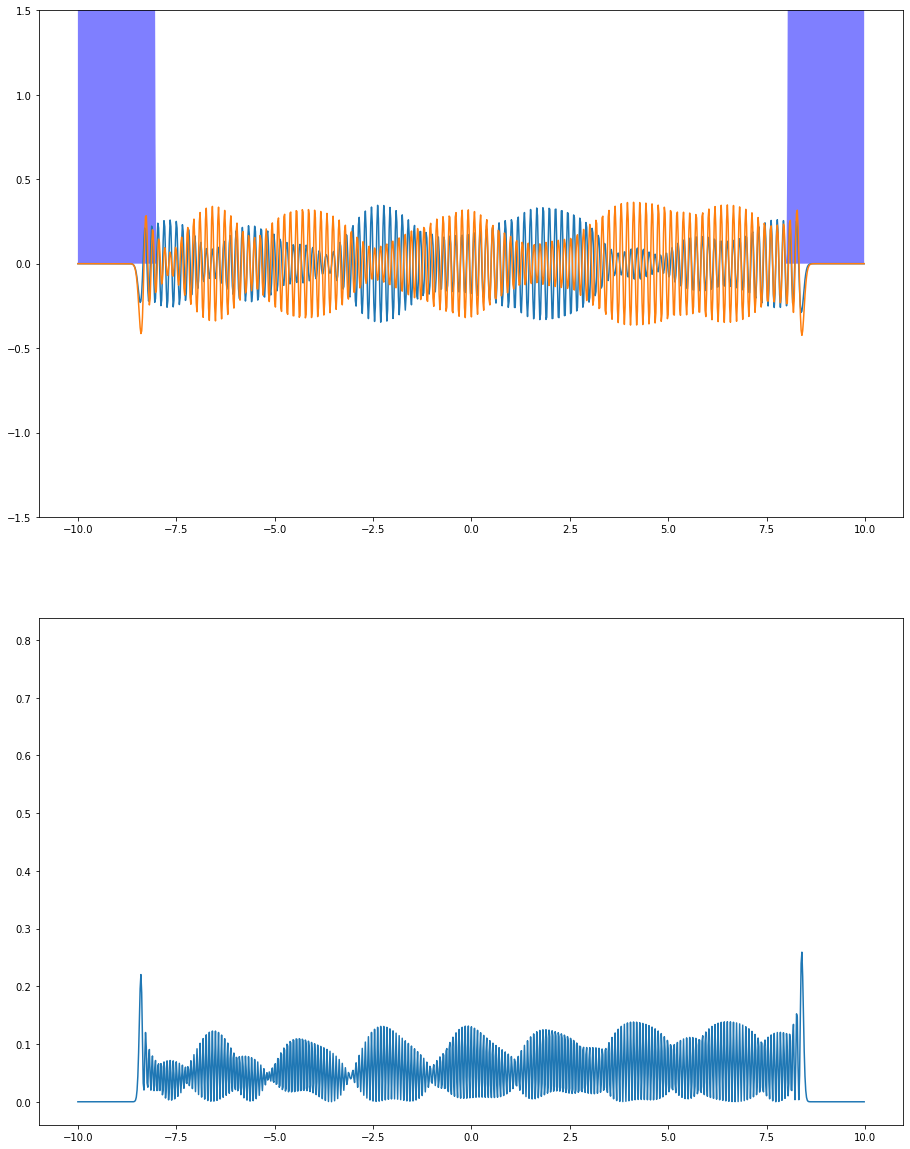

In [7]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(15.5, 20.5)
ax[0].set_ylim(-1.5, 1.5)
real_plot = ax[0].plot(sim.x, np.real(sim.psi))
imag_plot = ax[0].plot(sim.x, np.imag(sim.psi))
V_plot = ax[0].fill_between(sim.x, sim.V,facecolor='blue', alpha=0.5)
#prob_plot = plt.plot(sim.x, np.abs(sim.psi)**2)
#neg_prob_plot = plt.plot(sim.x, -np.abs(sim.psi)**2)
prob_plot = ax[1].plot(sim.x, np.abs(sim.psi)**2)
#energy_plot = ax[2].plot(sim.total_energy_timesteps, np.abs(sim.total_energy))

def animate(frame):
    sim.stepn(int(5e2))
    real_plot[0].set_data(sim.x, np.real(sim.psi))
    imag_plot[0].set_data(sim.x, np.imag(sim.psi))
    prob_plot[0].set_data(sim.x, np.abs(sim.psi)**2)
    #energy_plot[0].set_data(sim.total_energy_timesteps, np.abs(sim.total_energy))
    #prob_plot[0].set_data(sim.x, np.abs(sim.psi)**2)
    #neg_prob_plot[0].set_data(sim.x, -np.abs(sim.psi)**2)
anim = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
anim.save('infinite_square_well2.mp4', writer=writer1)

In [8]:
Video('infinite_square_well2.mp4')

As we can see, near the end of the sim, the particle is settling into the expected phase shifted TISE solution where it has a collection of places where it is 0 probability dependent on the wave number. In addition, because the well is much wider then the initial width of the particle, its energy level drops dramatically, but due to conservation of energy, its momentum goes up proportionally to account for this, resulting in the much higher wave number of the steady state solution then what we set in the initial conditions 

We can talk all day about the second order accuracy of the Split-Step Method, but a much more compelling argument for the accuracy of our sim is in the conservation of energy in the hamiltonian. Below, we present a graph showing the ratio of the total energy at a given second to the initial total energy of the particle. We see through the whole simulation that the hamiltonian remains constant.

(0.99, 1.01)

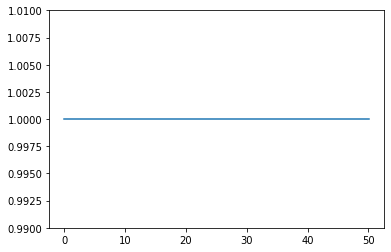

In [9]:
plt.plot(sim.total_energy_timesteps, np.array(sim.total_energy)/sim.total_energy[0])
ax = plt.gca()
ax.set_ylim(0.99, 1.01)


# Example 2: Tunneling in a well

In [10]:
sim = TDSE_sim(initial_position=-5, wavenumber=5, domain=20)
# infinite potential well
sim.V[sim.x < -8] = 1e3* (sim.x[sim.x < -8]+8)**2
sim.V[sim.x > 1] = 16.625 + 5
sim.V[sim.x > 1.3] = 0
sim.V[sim.x > 8] = 1e3*(sim.x[sim.x > 8]-8)**2


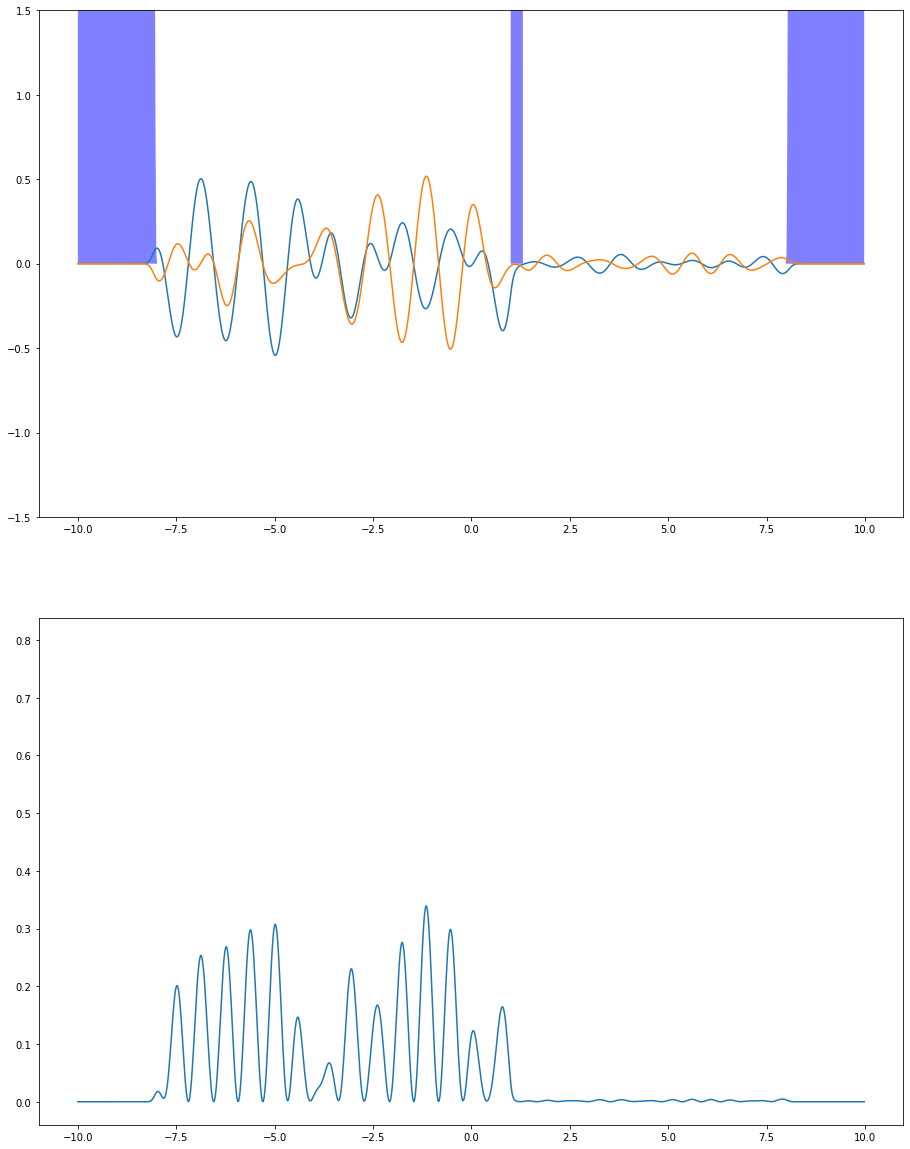

In [11]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(15.5, 20.5)
ax[0].set_ylim(-1.5, 1.5)
real_plot = ax[0].plot(sim.x, np.real(sim.psi))
imag_plot = ax[0].plot(sim.x, np.imag(sim.psi))
V_plot = ax[0].fill_between(sim.x, sim.V,facecolor='blue', alpha=0.5)
#prob_plot = plt.plot(sim.x, np.abs(sim.psi)**2)
#neg_prob_plot = plt.plot(sim.x, -np.abs(sim.psi)**2)
prob_plot = ax[1].plot(sim.x, np.abs(sim.psi)**2)
#energy_plot = ax[2].plot(sim.total_energy_timesteps, np.abs(sim.total_energy))

def animate(frame):
    sim.stepn(int(5e2))
    real_plot[0].set_data(sim.x, np.real(sim.psi))
    imag_plot[0].set_data(sim.x, np.imag(sim.psi))
    prob_plot[0].set_data(sim.x, np.abs(sim.psi)**2)
    #energy_plot[0].set_data(sim.total_energy_timesteps, np.abs(sim.total_energy))
    #prob_plot[0].set_data(sim.x, np.abs(sim.psi)**2)
    #neg_prob_plot[0].set_data(sim.x, -np.abs(sim.psi)**2)
anim = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
anim.save('tunneling_in_well.mp4', writer=writer1)

In [12]:
Video('tunneling_in_well.mp4')

# Example 3: Double Potential Well

In [13]:
sim = TDSE_sim(initial_position=-5, wavenumber=10, domain=20)
# infinite potential well
E_naut = 1.0

sim.V = 1.0*( 0.01* (1.3*sim.x)**4 - (1.3*sim.x)**2) +(16.625 + 8)
#sim.V[sim.x < -8] = 1e3* (sim.x[sim.x < -8]+8)**2
#sim.V[sim.x > 8] = 1e3*(sim.x[sim.x > 8]-8)**2
#sim.V = np.max(np.array([sim.V, np.ones(sim.V.shape)*-10.0]), axis=0)



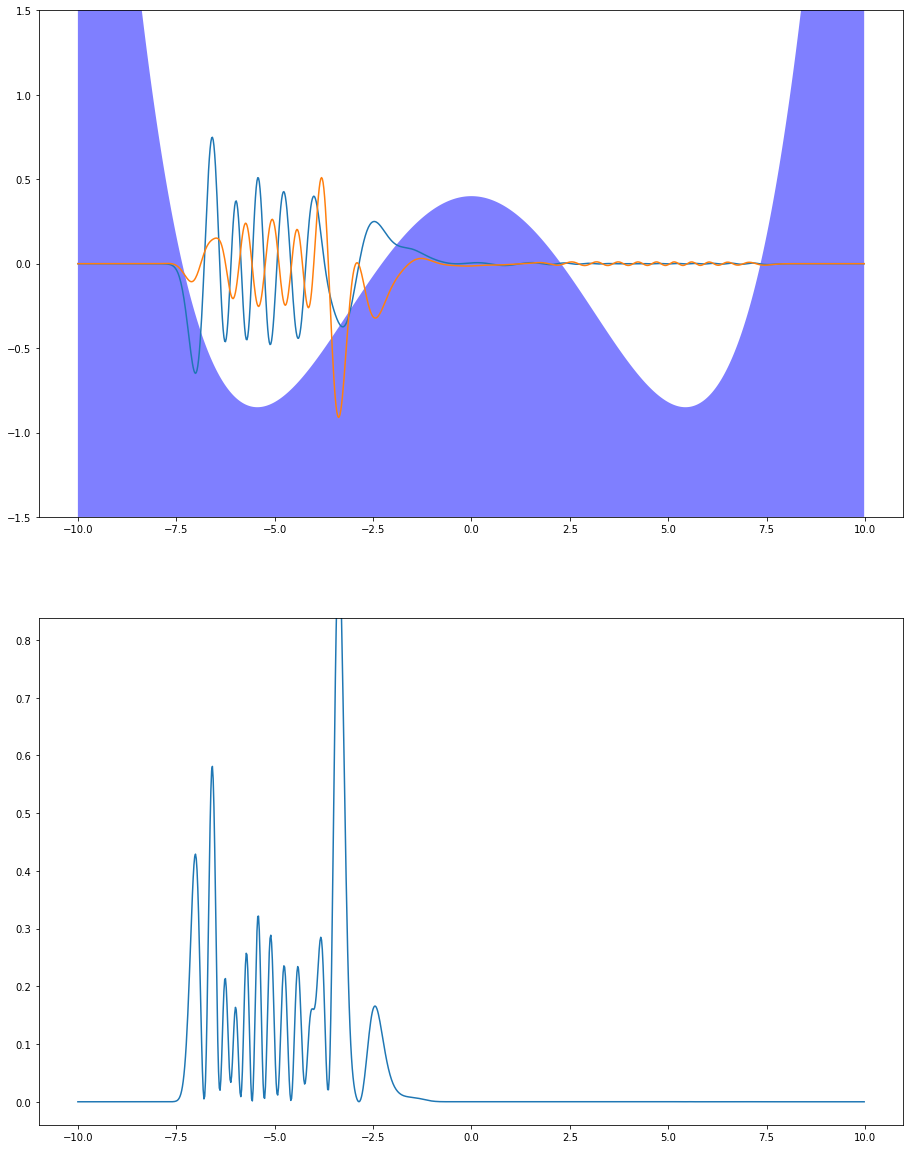

In [14]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(15.5, 20.5)
ax[0].set_ylim(-1.5, 1.5)
real_plot = ax[0].plot(sim.x, np.real(sim.psi))
imag_plot = ax[0].plot(sim.x, np.imag(sim.psi))
V_plot = ax[0].fill_between(sim.x, (sim.V - 133.0/8)/20.0, y2=-1.5, facecolor='blue', alpha=0.5)
#prob_plot = plt.plot(sim.x, np.abs(sim.psi)**2)
#neg_prob_plot = plt.plot(sim.x, -np.abs(sim.psi)**2)
prob_plot = ax[1].plot(sim.x, np.abs(sim.psi)**2)
#energy_plot = ax[2].plot(sim.total_energy_timesteps, np.abs(sim.total_energy))

def animate(frame):
    sim.stepn(int(5e2))
    real_plot[0].set_data(sim.x, np.real(sim.psi))
    imag_plot[0].set_data(sim.x, np.imag(sim.psi))
    prob_plot[0].set_data(sim.x, np.abs(sim.psi)**2)
    #energy_plot[0].set_data(sim.total_energy_timesteps, np.abs(sim.total_energy))
    #prob_plot[0].set_data(sim.x, np.abs(sim.psi)**2)
    #neg_prob_plot[0].set_data(sim.x, -np.abs(sim.psi)**2)
anim = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
anim.save('double_potential_well.mp4', writer=writer1)

In [15]:
Video('double_potential_well.mp4')